**Processing Sequences Using RNNs and CNNs**

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Aller dans le menu Execution > Modifier le type d'execution et selectionner GPU")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Basic RNNs

We will first create a simple RNN

## Generate the Dataset

We start by generating some data

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Let's plot our data :

Saving figure time_series_plot


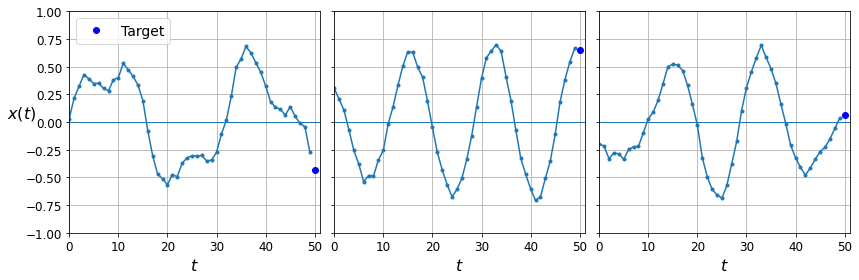

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

## Computing Some Baselines

It is a good pratice to start with some quick baseline.

First : naive predictions (just predict the last observed value):

In [7]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.01990768

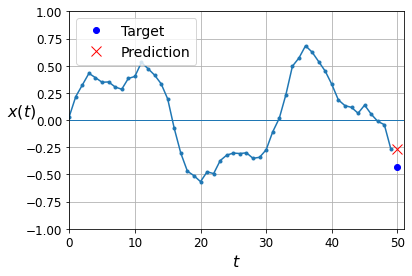

In [8]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

**Remarks :** We can see the predictions are close to the target.


Let's make a bit more complexe prediction : Linear predictions:

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 6ms/step - loss: 0.0965 - val_loss: 0.0407
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0273 - val_loss: 0.0187
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0157 - val_loss: 0.0127
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0118 - val_loss: 0.0101
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0098 - val_loss: 0.0085
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0083 - val_loss: 0.0073
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0072 - val_loss: 0.0064
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0052 - val_loss: 0.0050

In [12]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0035


0.0035056474152952433

63/63 [==============================] - 0s 1ms/step


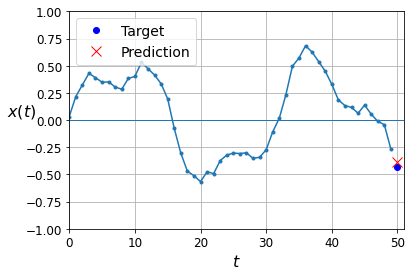

In [13]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

**Remarks :** With this second model, the predictions had reached the target.

## Using a Simple RNN

Now we will build a RNN !

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 9s 30ms/step - loss: 0.2438 - val_loss: 0.1622
Epoch 2/20
219/219 [==============================] - 8s 36ms/step - loss: 0.1078 - val_loss: 0.0666
Epoch 3/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0404 - val_loss: 0.0229
Epoch 4/20
219/219 [==============================] - 8s 34ms/step - loss: 0.0163 - val_loss: 0.0123
Epoch 5/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0118 - val_loss: 0.0110
Epoch 6/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 7/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0113 - val_loss: 0.0109
Epoch 8/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 9/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 10/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0112 - val_

In [15]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 13ms/step - loss: 0.0108


0.010807827115058899

63/63 [==============================] - 1s 12ms/step


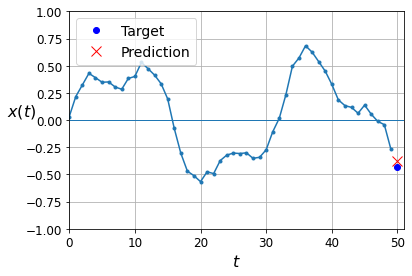

In [16]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

Let's go further and create a deep RNN :

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 32s 126ms/step - loss: 0.0185 - val_loss: 0.0042
Epoch 2/20
219/219 [==============================] - 31s 141ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 3/20
219/219 [==============================] - 29s 135ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 27s 124ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 5/20
219/219 [==============================] - 28s 129ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 6/20
219/219 [==============================] - 32s 145ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 7/20
219/219 [==============================] - 28s 126ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 8/20
219/219 [==============================] - 28s 128ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 27s 124ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 28s 129ms/step - l

In [18]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 13ms/step - loss: 0.0026


0.0026381569914519787

63/63 [==============================] - 1s 12ms/step


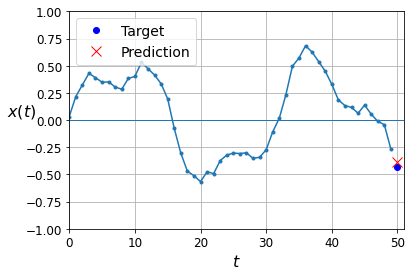

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

We want to make the second `SimpleRNN` layer to return only the last output:

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 20s 84ms/step - loss: 0.0180 - val_loss: 0.0050
Epoch 2/20
219/219 [==============================] - 18s 81ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 18s 82ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 18s 84ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 18s 80ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 6/20
219/219 [==============================] - 23s 107ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 19s 85ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 8/20
219/219 [==============================] - 24s 108ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 18s 81ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 10/20
219/219 [==============================] - 22s 99ms/step - loss: 0.0

In [21]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 9ms/step - loss: 0.0028


0.0027891863137483597

63/63 [==============================] - 1s 9ms/step


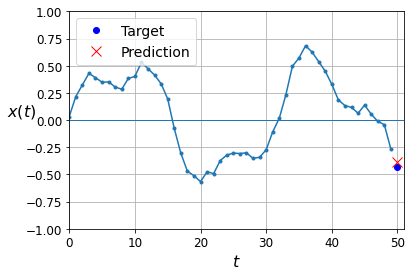

In [22]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

**Remarks:** We can observe that the results are the same as previously.

## Forecasting Several Steps Ahead

Now let's use our model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [23]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [24]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)
Y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 1s 11ms/step


In [25]:
Y_pred.shape

(2000, 10)

In [26]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.019991303

In [27]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

Saving figure forecast_ahead_plot


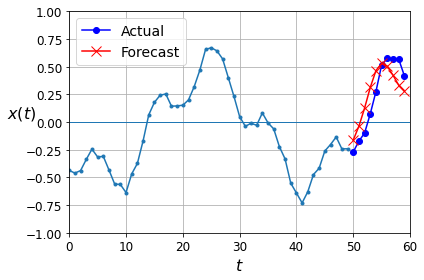

In [28]:
plot_multiple_forecasts(X_valid, Y_valid, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Our forecasts are really closed of the actual values !

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [29]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value, and repeat it 10 times
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

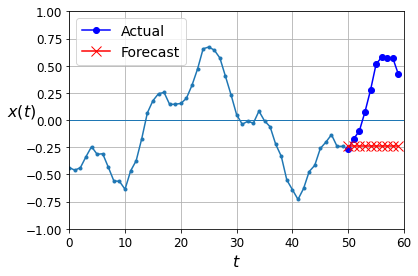

In [30]:
plot_multiple_forecasts(X_valid, Y_valid, Y_naive_pred)
plt.show()

In [31]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))
Y_lin_pred = model.predict(X_valid)

Epoch 1/20
219/219 [==============================] - 2s 4ms/step - loss: 0.1372 - val_loss: 0.0712
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0558 - val_loss: 0.0463
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0414 - val_loss: 0.0377
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0353 - val_loss: 0.0331
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0315 - val_loss: 0.0299
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0288 - val_loss: 0.0278
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0268 - val_loss: 0.0260
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0254 - val_loss: 0.0246
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0242 - val_loss: 0.0237
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0233 - val_loss: 0.0228

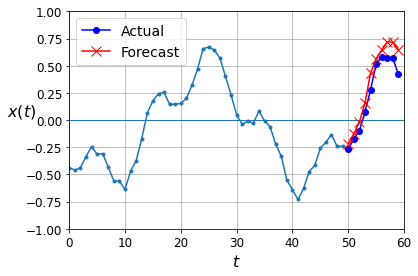

In [32]:
plot_multiple_forecasts(X_valid, Y_valid, Y_lin_pred)
plt.show()

**Remarks:** We get better forecasts

Now let's create an RNN that predicts all 10 next values at once:

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 22s 85ms/step - loss: 0.0635 - val_loss: 0.0332
Epoch 2/20
219/219 [==============================] - 17s 80ms/step - loss: 0.0278 - val_loss: 0.0213
Epoch 3/20
219/219 [==============================] - 18s 84ms/step - loss: 0.0174 - val_loss: 0.0158
Epoch 4/20
219/219 [==============================] - 17s 79ms/step - loss: 0.0140 - val_loss: 0.0131
Epoch 5/20
219/219 [==============================] - 17s 79ms/step - loss: 0.0125 - val_loss: 0.0132
Epoch 6/20
219/219 [==============================] - 19s 87ms/step - loss: 0.0117 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 24s 109ms/step - loss: 0.0109 - val_loss: 0.0105
Epoch 8/20
219/219 [==============================] - 17s 79ms/step - loss: 0.0105 - val_loss: 0.0102
Epoch 9/20
219/219 [==============================] - 18s 84ms/step - loss: 0.0103 - val_loss: 0.0101
Epoch 10/20
219/219 [==============================] - 17s 79ms/step - loss: 0.01

In [39]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 0s 199ms/step


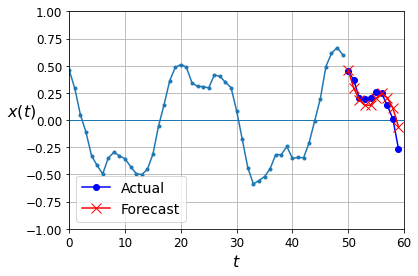

In [40]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [41]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [42]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [43]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 21s 82ms/step - loss: 0.0503 - last_time_step_mse: 0.0404 - val_loss: 0.0428 - val_last_time_step_mse: 0.0318
Epoch 2/20
219/219 [==============================] - 18s 83ms/step - loss: 0.0370 - last_time_step_mse: 0.0248 - val_loss: 0.0309 - val_last_time_step_mse: 0.0167
Epoch 3/20
219/219 [==============================] - 18s 80ms/step - loss: 0.0305 - last_time_step_mse: 0.0178 - val_loss: 0.0292 - val_last_time_step_mse: 0.0159
Epoch 4/20
219/219 [==============================] - 18s 81ms/step - loss: 0.0283 - last_time_step_mse: 0.0162 - val_loss: 0.0256 - val_last_time_step_mse: 0.0134
Epoch 5/20
219/219 [==============================] - 18s 82ms/step - loss: 0.0260 - last_time_step_mse: 0.0144 - val_loss: 0.0228 - val_last_time_step_mse: 0.0102
Epoch 6/20
219/219 [==============================] - 17s 79ms/step - loss: 0.0227 - last_time_step_mse: 0.0108 - val_loss: 0.0212 - val_last_time_step_mse: 0.0094
Epoch 7/20
219/2

In [44]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 207ms/step


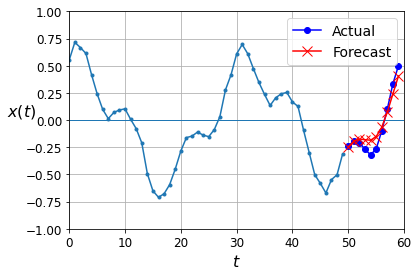

In [45]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# LSTMs

Now let's play with LSTMs :

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.2605 - last_time_step_mse: 0.2611 - val_loss: 0.2586 - val_last_time_step_mse: 0.2550
Epoch 2/20
219/219 [==============================] - 1s 2ms/step - loss: 0.2605 - last_time_step_mse: 0.2611 - val_loss: 0.2586 - val_last_time_step_mse: 0.2550
Epoch 3/20
219/219 [==============================] - 1s 2ms/step - loss: 0.2605 - last_time_step_mse: 0.2611 - val_loss: 0.2586 - val_last_time_step_mse: 0.2550
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.2605 - last_time_step_mse: 0.2611 - val_loss: 0.2586 - val_last_time_step_mse: 0.2550
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.2605 - last_time_step_mse: 0.2611 - val_loss: 0.2586 - val_last_time_step_mse: 0.2550
Epoch 6/20
219/219 [==============================] - 1s 2ms/step - loss: 0.2605 - last_time_step_mse: 0.2611 - val_loss: 0.2586 - val_last_time_step_mse: 0.2550
Epoch 7/20
219/219 [========

In [47]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.2586 - last_time_step_mse: 0.2550


[0.25859400629997253, 0.2549777030944824]

In [52]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 26ms/step


ValueError: ignored

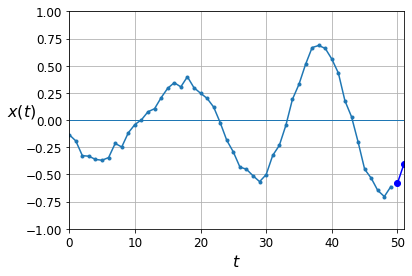

In [53]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRUs

And finally let's use a GRU

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 11ms/step - loss: 0.0726 - last_time_step_mse: 0.0643 - val_loss: 0.0527 - val_last_time_step_mse: 0.0416
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0482 - last_time_step_mse: 0.0378 - val_loss: 0.0451 - val_last_time_step_mse: 0.0338
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0416 - last_time_step_mse: 0.0298 - val_loss: 0.0390 - val_last_time_step_mse: 0.0253
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0361 - last_time_step_mse: 0.0227 - val_loss: 0.0338 - val_last_time_step_mse: 0.0185
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0328 - last_time_step_mse: 0.0182 - val_loss: 0.0324 - val_last_time_step_mse: 0.0175
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0311 - last_time_step_mse: 0.0163 - val_loss: 0.0305 - val_last_time_step_mse: 0.0152
Epoch 7/20
219/219 [======

In [55]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0227 - last_time_step_mse: 0.0094


[0.022730262950062752, 0.009411539882421494]

In [56]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 1s 535ms/step


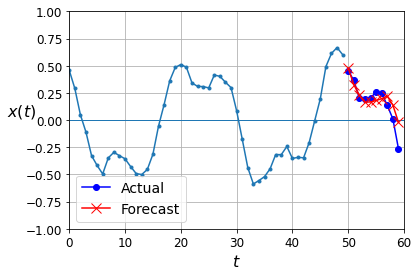

In [57]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [58]:
model = keras.models.Sequential([
# Add a Conv1D layer with 20 filters, a kernel size of 4 and a valid padding here
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 11s 12ms/step - loss: 0.0716 - last_time_step_mse: 0.0648 - val_loss: 0.0427 - val_last_time_step_mse: 0.0345
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0370 - last_time_step_mse: 0.0297 - val_loss: 0.0322 - val_last_time_step_mse: 0.0237
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0304 - last_time_step_mse: 0.0222 - val_loss: 0.0285 - val_last_time_step_mse: 0.0191
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0273 - last_time_step_mse: 0.0178 - val_loss: 0.0267 - val_last_time_step_mse: 0.0166
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0252 - last_time_step_mse: 0.0149 - val_loss: 0.0249 - val_last_time_step_mse: 0.0148
Epoch 6/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0238 - last_time_step_mse: 0.0132 - val_loss: 0.0233 - val_last_time_step_mse: 0.0124
Epoch 7/20
219/219 [=====

Compare the results to the other models :

## 8. Tackling the SketchRNN Dataset

We want to train a classification model for the SketchRNN dataset

The dataset is not available in TFDS yet, the [pull request](https://github.com/tensorflow/datasets/pull/361) is still work in progress. Luckily, the data is conveniently available as TFRecords, so let's download it (it might take a while, as it's about 1 GB large, with 3,450,000 training sketches and 345,000 test sketches):

In [59]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

1065301781/1065301781 [==============================] - 12s 0us/step


In [60]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [61]:
train_files

['/root/.keras/datasets/quickdraw/training.tfrecord-00000-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00001-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00002-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00003-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00004-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00005-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00006-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00007-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00008-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00009-of-00010']

In [62]:
eval_files

['/root/.keras/datasets/quickdraw/eval.tfrecord-00000-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00001-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00002-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00003-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00004-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00005-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00006-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00007-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00008-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00009-of-00010']

In [63]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [64]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [65]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [66]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [67]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [68]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [69]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.0944882  -0.04663213  0.        ]
  [-0.08661417  0.04145078  0.        ]
  [-0.03937007  0.05181348  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.04313726 -0.14960629  0.        ]
  [ 0.06274509 -0.40551183  0.        ]
  [ 0.04313726 -0.12598425  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          1.        ]
  [ 0.          0.          0.        ]
  [-0.19607842 -0.03174603  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.12790698  0.01960784  0.        ]
  [-0.02906978  0.2117647   0.        ]
  [-0.04651159  0.06274509  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

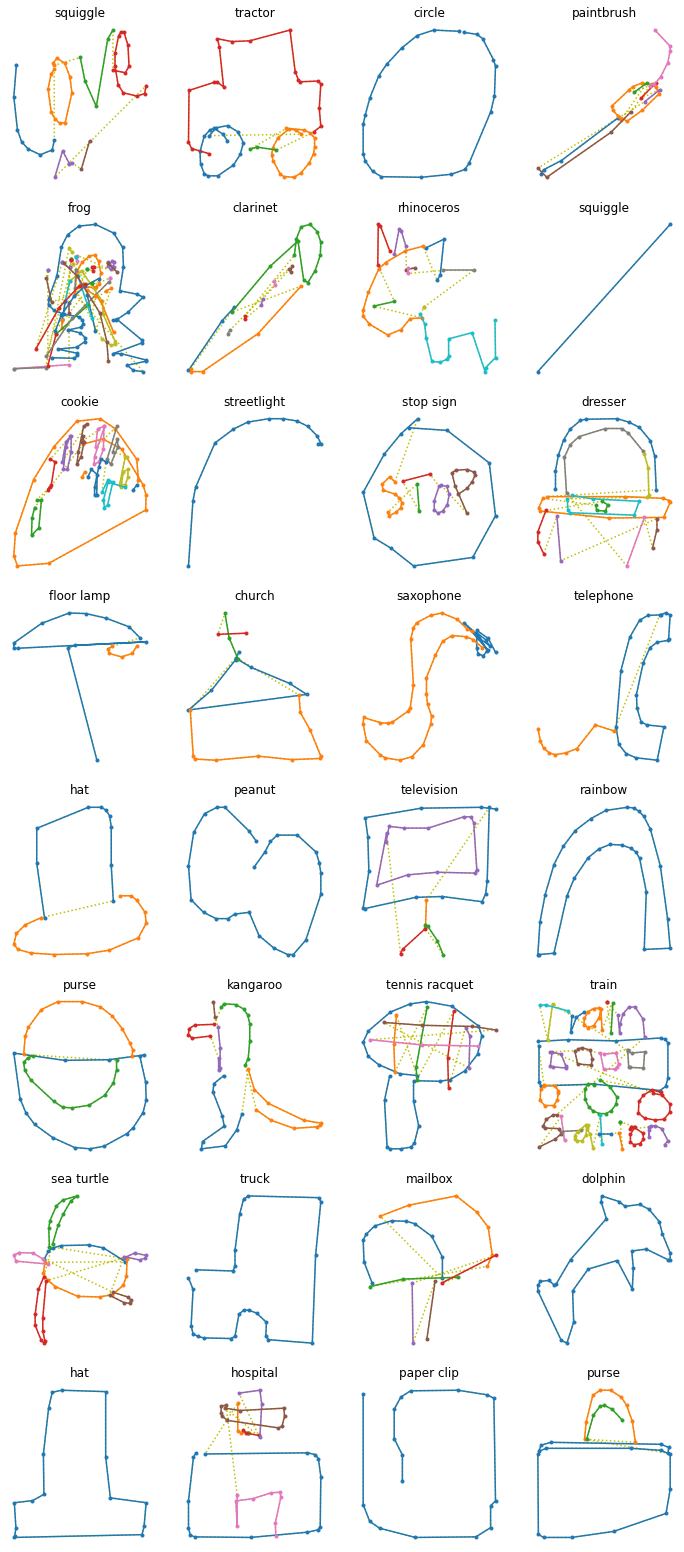

In [70]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

Most sketches are composed of less than 100 points:

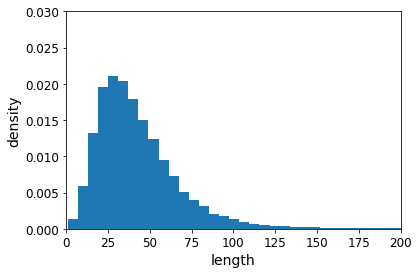

In [71]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [72]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [74]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
  18048/Unknown - 226s 12ms/step - loss: 5.4783 - accuracy: 0.0162 - sparse_top_k_categorical_accuracy: 0.0670

KeyboardInterrupt: ignored

In [ ]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [ ]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

In [ ]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))